In [1]:
!pip install ultralytics pycocotools


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

Training Data

In [2]:
!mkdir -p fashionpedia_data/images
!wget https://s3.amazonaws.com/ifashionist-dataset/images/train2020.zip
!unzip train2020.zip -d fashionpedia_data/images

!wget https://s3.amazonaws.com/ifashionist-dataset/annotations/instances_attributes_train2020.json -O fashionpedia_data/annotations.json


Streaming output truncated to the last 5000 lines.
  inflating: fashionpedia_data/images/train/43929c91575dc1d8a0aebc4f5ac7592d.jpg  
  inflating: fashionpedia_data/images/train/c3045c901c4c91d7564a3407d351d1b5.jpg  
  inflating: fashionpedia_data/images/train/fe6bdd2397004cd9be166166626d42ba.jpg  
  inflating: fashionpedia_data/images/train/fd191f5c7af85e75c8804d2b9c51fb41.jpg  
  inflating: fashionpedia_data/images/train/26bf90cdaa9a8c53e77fa2dfdd95e8ab.jpg  
  inflating: fashionpedia_data/images/train/90f7b670670c413fba1915ffd991f397.jpg  
  inflating: fashionpedia_data/images/train/0b062539376c8b64dde6ddde6e538fa3.jpg  
  inflating: fashionpedia_data/images/train/4a6a588efa50a4bbebd81b32892fa6ea.jpg  
  inflating: fashionpedia_data/images/train/1c48b6c1069d148c13fa04dd6986b064.jpg  
  inflating: fashionpedia_data/images/train/7b2727a27efa82786432bffc5abe05b6.jpg  
  inflating: fashionpedia_data/images/train/b3b4d9a06c4ffc1e86be336d4fbc3380.jpg  
  inflating: fashionpedia_data/image

In [3]:
import os, json
from tqdm import tqdm

with open("/content/fashionpedia_data/annotations.json") as f:
    data = json.load(f)

categories = {cat['id']: cat['name'] for cat in data['categories']}
cat_map = {cat_id: idx for idx, cat_id in enumerate(categories)}
names = [categories[cid] for cid in sorted(categories)]

os.makedirs("/content/fashionpedia_yolo/images/train", exist_ok=True)
os.makedirs("/content/fashionpedia_yolo/labels/train", exist_ok=True)

img_id_to_filename = {img['id']: img['file_name'] for img in data['images']}
img_id_to_size = {img['id']: (img['width'], img['height']) for img in data['images']}

# Copy images and write YOLO labels
for ann in tqdm(data['annotations']):
    img_id = ann['image_id']
    fname = img_id_to_filename[img_id]
    width, height = img_id_to_size[img_id]
    cid = ann['category_id']

    if cid not in cat_map:
        continue

    x, y, w, h = ann['bbox']
    x_c = (x + w / 2) / width
    y_c = (y + h / 2) / height
    x_n = w / width
    y_n = h / height

    label_name = os.path.splitext(fname)[0] + ".txt"
    label_path = os.path.join("fashionpedia_yolo", "labels/train", label_name)

    with open(label_path, "a") as f:
        f.write(f"{cat_map[cid]} {x_c:.6f} {y_c:.6f} {x_n:.6f} {y_n:.6f}\n")

    import shutil
    src_path = f"/content/fashionpedia_data/images/train/{fname}"
    dst_path = f"/content/fashionpedia_yolo/images/train/{fname}"
    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)


100%|██████████| 333401/333401 [03:15<00:00, 1701.76it/s]


In [4]:
print("Classes (YOLO format):")
for i, name in enumerate(names):
    print(f"{i}: {name}")


Classes (YOLO format):
0: shirt, blouse
1: top, t-shirt, sweatshirt
2: sweater
3: cardigan
4: jacket
5: vest
6: pants
7: shorts
8: skirt
9: coat
10: dress
11: jumpsuit
12: cape
13: glasses
14: hat
15: headband, head covering, hair accessory
16: tie
17: glove
18: watch
19: belt
20: leg warmer
21: tights, stockings
22: sock
23: shoe
24: bag, wallet
25: scarf
26: umbrella
27: hood
28: collar
29: lapel
30: epaulette
31: sleeve
32: pocket
33: neckline
34: buckle
35: zipper
36: applique
37: bead
38: bow
39: flower
40: fringe
41: ribbon
42: rivet
43: ruffle
44: sequin
45: tassel


Validation Data

In [5]:
!mkdir -p fashionpedia_data/images
!wget https://s3.amazonaws.com/ifashionist-dataset/images/val_test2020.zip
!unzip val_test2020.zip -d fashionpedia_data/images

!wget https://s3.amazonaws.com/ifashionist-dataset/annotations/instances_attributes_val2020.json -O fashionpedia_data/annotations_test.json

--2025-07-12 14:09:48--  https://s3.amazonaws.com/ifashionist-dataset/images/val_test2020.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.176.45, 16.15.216.202, 52.217.122.176, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.176.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 236499034 (226M) [application/zip]
Saving to: ‘val_test2020.zip’

val_test2020.zip    100%[===================>] 225.54M  15.0MB/s    in 17s     

2025-07-12 14:10:06 (13.5 MB/s) - ‘val_test2020.zip’ saved [236499034/236499034]

Archive:  val_test2020.zip
   creating: fashionpedia_data/images/test/
  inflating: fashionpedia_data/images/test/968a55c5e4d4d763b0007b1fa8993644.jpg  
  inflating: fashionpedia_data/images/test/93689df6d05b8406fcf9083057344e3e.jpg  
  inflating: fashionpedia_data/images/test/63428001d1dead4d5afcbabfc9777c67.jpg  
  inflating: fashionpedia_data/images/test/90b3a9254b942e4fb986258899b4d39c.jpg  
  inflating: fashionpedia_data/images/tes

In [6]:
import os, json
from tqdm import tqdm

with open("/content/fashionpedia_data/annotations_test.json") as f:
    data = json.load(f)

categories = {cat['id']: cat['name'] for cat in data['categories']}
cat_map = {cat_id: idx for idx, cat_id in enumerate(categories)}
names = [categories[cid] for cid in sorted(categories)]

os.makedirs("/content/fashionpedia_yolo/images/test", exist_ok=True)
os.makedirs("/content/fashionpedia_yolo/labels/test", exist_ok=True)

img_id_to_filename = {img['id']: img['file_name'] for img in data['images']}
img_id_to_size = {img['id']: (img['width'], img['height']) for img in data['images']}

import shutil  # move import to the top (optional but clean)

# Copy images and write YOLO labels
for ann in tqdm(data['annotations']):
    img_id = ann['image_id']
    fname = img_id_to_filename[img_id]
    width, height = img_id_to_size[img_id]
    cid = ann['category_id']

    if cid not in cat_map:
        continue

    x, y, w, h = ann['bbox']
    x_c = (x + w / 2) / width
    y_c = (y + h / 2) / height
    x_n = w / width
    y_n = h / height

    label_name = os.path.splitext(fname)[0] + ".txt"
    label_path = os.path.join("/content/fashionpedia_yolo/labels/test", label_name)

    with open(label_path, "a") as f:
        f.write(f"{cat_map[cid]} {x_c:.6f} {y_c:.6f} {x_n:.6f} {y_n:.6f}\n")

    src_path = f"/content/fashionpedia_data/images/test/{fname}"
    dst_path = f"/content/fashionpedia_yolo/images/test/{fname}"
    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)


100%|██████████| 8781/8781 [00:03<00:00, 2739.31it/s]


In [7]:
import yaml

data_yaml = {
    'train': '/content/fashionpedia_yolo/images/train',
    'val': '/content/fashionpedia_yolo/images/test',
    'nc': len(names),
    'names': names
}

with open("/content/fashionpedia_yolo/data.yaml", "w") as f:
    yaml.dump(data_yaml, f)


In [ ]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')
model.train(data="/content/fashionpedia_yolo/data.yaml", epochs=50, imgsz=640)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 251MB/s]

Ultralytics 8.3.165 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)


engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/fashionpedia_yolo/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, project=None, rect=False, resume=False, retina_masks=

100%|██████████| 755k/755k [00:00<00:00, 124MB/s]

Overriding model.yaml nc=80 with nc=46

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

Model summary: 129 layers, 3,019,818 parameters, 3,019,802 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 334MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 16.7±3.2 MB/s, size: 81.3 KB)


train: Scanning /content/fashionpedia_yolo/labels/train... 45623 images, 0 backgrounds, 0 corrupt: 100%|██████████| 45623/45623 [01:50<00:00, 414.43it/s]

train: /content/fashionpedia_yolo/images/train/5338ebf9a0b472901fa2c29f9b333817.jpg: 1 duplicate labels removed


train: New cache created: /content/fashionpedia_yolo/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 18.3±2.6 MB/s, size: 79.7 KB)


val: Scanning /content/fashionpedia_yolo/labels/test... 1158 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1158/1158 [00:03<00:00, 356.43it/s]

val: New cache created: /content/fashionpedia_yolo/labels/test.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25         3G      1.293      2.572      1.348         96        640: 100%|██████████| 2852/2852 [16:14<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:13<00:00,  2.75it/s]


                   all       1158       8781      0.697      0.201      0.212      0.145

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      3.17G        1.2      1.701      1.249         94        640: 100%|██████████| 2852/2852 [15:43<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:11<00:00,  3.12it/s]


                   all       1158       8781      0.619      0.238      0.249      0.171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      3.18G      1.225      1.641      1.257         78        640: 100%|██████████| 2852/2852 [15:43<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:11<00:00,  3.24it/s]


                   all       1158       8781      0.578      0.269      0.265      0.179

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25       3.2G      1.218      1.538      1.253         93        640: 100%|██████████| 2852/2852 [15:16<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:11<00:00,  3.27it/s]


                   all       1158       8781      0.553      0.291      0.303      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      3.21G      1.168      1.403      1.223        101        640: 100%|██████████| 2852/2852 [15:05<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:10<00:00,  3.38it/s]


                   all       1158       8781      0.582      0.319      0.326      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      3.22G      1.137      1.333      1.206        106        640: 100%|██████████| 2852/2852 [14:50<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:10<00:00,  3.40it/s]


                   all       1158       8781      0.567      0.324      0.346      0.247

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      3.23G      1.112      1.282       1.19         76        640: 100%|██████████| 2852/2852 [14:58<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:11<00:00,  3.29it/s]


                   all       1158       8781      0.585      0.332      0.367      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      3.42G      1.097      1.246      1.182         70        640: 100%|██████████| 2852/2852 [15:01<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:11<00:00,  3.32it/s]


                   all       1158       8781      0.576      0.349      0.377      0.267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      3.43G      1.081      1.216       1.17         71        640: 100%|██████████| 2852/2852 [15:02<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:10<00:00,  3.39it/s]


                   all       1158       8781      0.558      0.385      0.382      0.273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      3.44G      1.065       1.19      1.162         98        640: 100%|██████████| 2852/2852 [14:48<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:09<00:00,  3.71it/s]


                   all       1158       8781      0.671      0.363      0.395      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      3.46G      1.054      1.169      1.156         94        640: 100%|██████████| 2852/2852 [14:54<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:10<00:00,  3.40it/s]


                   all       1158       8781      0.601      0.381      0.397      0.288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      3.46G      1.044      1.151      1.152        223        640:  41%|████      | 1160/2852 [05:55<08:38,  3.26it/s]


KeyboardInterrupt: 


image 1/1 /content/fashionpedia_yolo/images/train/0004467156e47b0eb6de4aa6479cbd15.jpg: 640x448 1 dress, 1 headband, head covering, hair accessory, 1 sleeve, 1 neckline, 1 bead, 8.7ms
Speed: 3.4ms preprocess, 8.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)


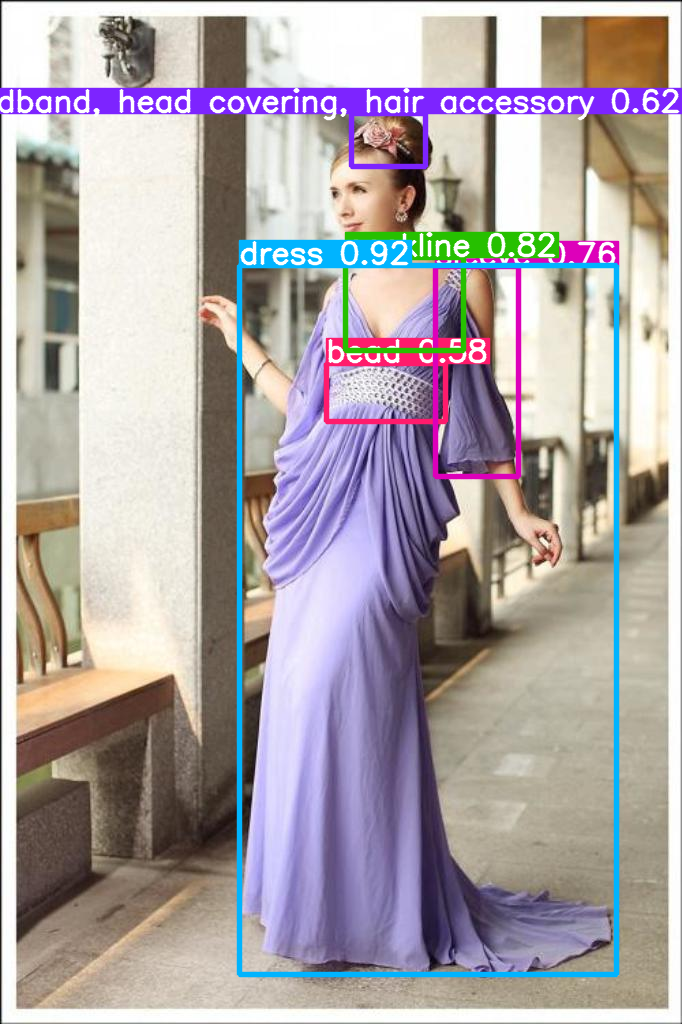

In [11]:
model = YOLO("/content/runs/detect/train/weights/best.pt")
results = model("/content/fashionpedia_yolo/images/train/0004467156e47b0eb6de4aa6479cbd15.jpg")
results[0].show()

In [ ]:
from glob import glob
from os.path import basename

label_files = glob("/content/fashionpedia_yolo/images/train/*.txt")

empty = 0
non_empty = 0

for f in label_files:
    with open(f, "r") as file:
        lines = file.readlines()
        if len(lines) == 0:
            empty += 1
        else:
            non_empty += 1

print(f"✅ Non-empty label files: {non_empty}")
print(f"⚠️ Empty label files: {empty}")


In [12]:
!mkdir -p /content/flickd

# Copy notebook
!cp /content/Faishon_Dataset_Yolov8.ipynb /content/flickd/

# Copy model weights
!cp /content/runs/detect/train/weights/best.pt /content/flickd/

# Copy label plot
!cp /content/runs/detect/train/labels.jpg /content/flickd/

# Copy dataset config
!cp /content/fashionpedia_yolo/data.yaml /content/flickd/

# (Optional) Copy any prediction images or graphs


cp: cannot stat '/content/Faishon_Dataset_Yolov8.ipynb': No such file or directory
